In [1]:
import numpy as np
import os

In [3]:
import numpy as np
import os
import json
from data_reader import load_data # Make sure data_reader.py is accessible
from collections import defaultdict

# --- Configuration (Copied from your next cell) ---
JSON_FILE = 'WLASL_Cafe.json'
LANDMARK_FOLDER = 'landmarks'
NUM_POSE = 33
NUM_HAND = 21
NUM_LANDMARKS = NUM_POSE + (2 * NUM_HAND)  # 75 total
NUM_VALUES_PER_LANDMARK = 4
EXPECTED_FEATURES = NUM_LANDMARKS * NUM_VALUES_PER_LANDMARK # 300

VIABLE_GLOSSES = [
    'can', 'drink', 'eat', 'finish', 'go', 'help', 'hot', 'like',
    'need', 'no', 'table', 'time', 'what', 'yes' 
    # (This list should be identical to the one in your next cell)
]
# --- End Configuration ---


print("--- Checking Original (Pre-Augmentation) Data Counts ---")
print(f"Loading all labels from {JSON_FILE}...")
all_instances_full = load_data(JSON_FILE)

print(f"Filtering instances for the {len(VIABLE_GLOSSES)} viable glosses...")
all_instances_subset = [
    inst for inst in all_instances_full if inst.get('gloss') in VIABLE_GLOSSES
]

print(f"Found {len(all_instances_subset)} total instances for subset in JSON.")
print(f"Checking existing landmarks in '{LANDMARK_FOLDER}'...")

# --- Counters for each split ---
counts_train = defaultdict(int)
counts_val = defaultdict(int)
counts_test = defaultdict(int)
counts_total = defaultdict(int)
total_found_landmarks = 0

# --- Loop through subset and check for existing .npy files ---
for instance in all_instances_subset:
    video_id = instance.get('video_id')
    gloss = instance.get('gloss')
    split = instance.get('split')
    
    if not (video_id and gloss and split):
        continue # Skip if essential info is missing

    landmark_file = f"{video_id}.npy"
    landmark_path = os.path.join(LANDMARK_FOLDER, landmark_file)

    # Check if the landmark file actually exists
    if os.path.exists(landmark_path):
        # Optional: Check for correct shape to be 100% sure
        try:
            landmarks = np.load(landmark_path)
            if landmarks.size == 0 or len(landmarks.shape) != 2 or landmarks.shape[1] != EXPECTED_FEATURES:
                # print(f"Skipping {video_id} ({gloss}) - incorrect shape/empty.") # Uncomment for debug
                continue
        except Exception as e:
            # print(f"Skipping {video_id} ({gloss}) - load error: {e}") # Uncomment for debug
            continue
            
        # If file exists and shape is good, increment counters
        total_found_landmarks += 1
        counts_total[gloss] += 1
        
        if split == 'train':
            counts_train[gloss] += 1
        elif split == 'val':
            counts_val[gloss] += 1
        elif split == 'test':
            counts_test[gloss] += 1

print("\n--- Original Sample Counts (Pre-Augmentation) ---")
for gloss in VIABLE_GLOSSES:
    print(f"  - {gloss}: {counts_total[gloss]} total ("
          f"{counts_train[gloss]} train, "
          f"{counts_val[gloss]} val, "
          f"{counts_test[gloss]} test)")

print("-------------------------------------------------")
print(f"Total Original Samples Found: {total_found_landmarks}")
print("This is the data that will be loaded, split, and augmented in the next cell.")
print("-------------------------------------------------\n")

--- Checking Original (Pre-Augmentation) Data Counts ---
Loading all labels from WLASL_Cafe.json...
Loaded 839 video instances from WLASL_Cafe.json
Filtering instances for the 14 viable glosses...
Found 308 total instances for subset in JSON.
Checking existing landmarks in 'landmarks'...

--- Original Sample Counts (Pre-Augmentation) ---
  - can: 10 total (8 train, 1 val, 1 test)
  - drink: 18 total (13 train, 3 val, 2 test)
  - eat: 9 total (6 train, 2 val, 1 test)
  - finish: 14 total (8 train, 3 val, 3 test)
  - go: 16 total (11 train, 3 val, 2 test)
  - help: 11 total (7 train, 1 val, 3 test)
  - hot: 16 total (10 train, 3 val, 3 test)
  - like: 16 total (11 train, 3 val, 2 test)
  - need: 6 total (3 train, 1 val, 2 test)
  - no: 14 total (10 train, 3 val, 1 test)
  - table: 8 total (5 train, 1 val, 2 test)
  - time: 8 total (4 train, 2 val, 2 test)
  - what: 11 total (6 train, 3 val, 2 test)
  - yes: 16 total (10 train, 3 val, 3 test)
----------------------------------------------

In [2]:
#cell 2

import numpy as np
import os
import json
from data_reader import load_data # Import from your corrected data_reader.py

# --- Configuration ---
JSON_FILE = 'WLASL_Cafe.json' # Your specific JSON file
LANDMARK_FOLDER = 'landmarks' # Folder containing your .npy files
MAX_SEQ_LENGTH = 100 # Adjust based on your analysis (e.g., 100 frames)
NUM_POSE = 33
NUM_HAND = 21
NUM_LANDMARKS = NUM_POSE + (2 * NUM_HAND)  # 75 total
NUM_VALUES_PER_LANDMARK = 4                # x, y, z, visibility

OUTPUT_NPZ_FILE = 'prepared_subset_data.npz' # <<< CHANGED: Output file name for the subset data

# --- <<< MODIFICATION 1: DEFINE YOUR SUBSET OF GLOSSES >>> ---
# -----------------------------------------------------------------
# V V V V V V V  EDIT THIS LIST V V V V V V V V V V V V V V V V V V
# -----------------------------------------------------------------
# Fill this list with the exact gloss names you want to keep.
# Example: Choose glosses with > 7 available videos based on find_missing.py output
VIABLE_GLOSSES = [
    'can', 'drink', 'finish', 'go', 'help', 'hot', 'like',
    'need', 'no', 'table', 'time', 'what', 'yes', 'eat',
    # ADD MORE GLOSS NAMES HERE based on your data analysis!
    # Make sure the spelling matches the JSON file exactly.
]
# -----------------------------------------------------------------
# ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^
# -----------------------------------------------------------------
print(f"Targeting a subset of {len(VIABLE_GLOSSES)} glosses.")
# --- <<< END MODIFICATION 1 >>> ---


# --- Step 1: Load ALL Labels First ---
print(f"Loading all labels from {JSON_FILE}...")
all_instances_full = load_data(JSON_FILE)
if not all_instances_full:
    print("Error: No data loaded. Exiting.")
    exit()

# --- <<< MODIFICATION 2: FILTER INSTANCES FOR SUBSET >>> ---
print(f"Filtering instances for the {len(VIABLE_GLOSSES)} viable glosses...")
all_instances_subset = [
    inst for inst in all_instances_full if inst.get('gloss') in VIABLE_GLOSSES
]
if not all_instances_subset:
    print("Error: No instances found for the specified VIABLE_GLOSSES. Check spelling or list content. Exiting.")
    exit()
print(f"Found {len(all_instances_subset)} instances for the subset.")
# --- <<< END MODIFICATION 2 >>> ---


# --- Step 2: Create Lookup Dictionary for SUBSET ---
# Use the filtered list 'all_instances_subset' now
video_to_label_split = {}
found_ids_in_json_subset = set()
for instance in all_instances_subset: # <<< CHANGED: Use subset list
    video_id = instance.get('video_id')
    gloss = instance.get('gloss')
    split = instance.get('split')
    if video_id and gloss and split:
        video_to_label_split[video_id] = {'gloss': gloss, 'split': split}
        found_ids_in_json_subset.add(video_id)
    # No need for warning here

print(f"Created lookup dictionary for subset with {len(video_to_label_split)} entries.")


# --- Step 3: Label Encoding for SUBSET ---
print("Encoding labels for the subset...")
# Get unique glosses ONLY from the SUBSET data
subset_glosses = sorted(list(set(info['gloss'] for info in video_to_label_split.values())))
gloss_to_id = {gloss: i for i, gloss in enumerate(subset_glosses)}
id_to_gloss = {i: gloss for i, gloss in enumerate(subset_glosses)}
# <<< CHANGED: num_classes is now based on the subset >>>
num_classes = len(subset_glosses)

print(f"Found {num_classes} unique glosses in the subset.")
# print("Subset Gloss to ID mapping:", gloss_to_id) # Optional

# --- Helper Functions for Normalization and Padding ---
# (These functions remain exactly the same as before)
def normalize_landmarks(landmarks):
    """Normalizes landmarks by centering them around the nose (landmark 0)."""
    normalized_video = np.copy(landmarks)
    num_frames = landmarks.shape[0]
    num_features_per_frame = landmarks.shape[1]
    if num_features_per_frame != NUM_LANDMARKS * NUM_VALUES_PER_LANDMARK:
        print(f"  Warning: Unexpected feature count ({num_features_per_frame}). Skipping normalization.")
        return landmarks
    for frame_idx in range(num_frames):
        frame_data = landmarks[frame_idx]
        frame_reshaped = frame_data.reshape((NUM_LANDMARKS, NUM_VALUES_PER_LANDMARK))
        nose_x, nose_y = frame_reshaped[0, 0], frame_reshaped[0, 1]
        nose_visibility = frame_reshaped[0, 3]
        if nose_visibility > 0.1:
            frame_reshaped[:, 0] -= nose_x
            frame_reshaped[:, 1] -= nose_y
        else:
            frame_reshaped[:, :3] = 0.0
        normalized_video[frame_idx] = frame_reshaped.flatten()
    return normalized_video

def pad_truncate(landmarks, max_len):
    """Pads or truncates landmark sequence to a fixed length."""
    num_frames = landmarks.shape[0]
    num_features = landmarks.shape[1]
    padded_landmarks = np.zeros((max_len, num_features), dtype=np.float32)
    seq_len_to_use = min(num_frames, max_len)
    padded_landmarks[:seq_len_to_use] = landmarks[:seq_len_to_use]
    return padded_landmarks

# --- Step 4: Load SPECIFIC Landmarks, Normalize, Pad, and Split Data ---
print(f"\nProcessing subset landmark files from '{LANDMARK_FOLDER}'...")
X_train, y_train = [], []
X_val, y_val = [], []
X_test, y_test = [], []

processed_ids_subset = set()

# <<< CHANGED: Iterate ONLY through the video IDs relevant to our SUBSET >>>
for video_id in video_to_label_split.keys():
    landmark_file = f"{video_id}.npy"
    landmark_path = os.path.join(LANDMARK_FOLDER, landmark_file)

    # Check if the landmark file actually exists
    if os.path.exists(landmark_path):
        processed_ids_subset.add(video_id) # Track that we found the landmark file
        label_info = video_to_label_split[video_id]
        gloss = label_info['gloss']
        split = label_info['split']

        try:
            landmarks = np.load(landmark_path)
            # Basic validation checks
            if landmarks.size == 0 or landmarks.shape[0] == 0:
                 print(f"Warning: Skipping empty landmark file for {video_id} ({gloss}).")
                 continue
            if len(landmarks.shape) != 2 or landmarks.shape[1] != NUM_LANDMARKS * NUM_VALUES_PER_LANDMARK:
                 print(f"Warning: Skipping landmark file with unexpected shape {landmarks.shape} for {video_id} ({gloss}). Expected (frames, {NUM_LANDMARKS * NUM_VALUES_PER_LANDMARK})")
                 continue

            # Apply Normalization
            normalized_data = normalize_landmarks(landmarks)

            # Apply Padding/Truncation
            padded_data = pad_truncate(normalized_data, MAX_SEQ_LENGTH)

            # Get Numerical Label (using the SUBSET mapping)
            label_id = gloss_to_id[gloss]

            # Append data to the correct list based on split
            if split == 'train':
                X_train.append(padded_data)
                y_train.append(label_id)
            elif split == 'val':
                X_val.append(padded_data)
                y_val.append(label_id)
            elif split == 'test':
                X_test.append(padded_data)
                y_test.append(label_id)
            # No 'else' needed here since we pre-filtered splits

        except Exception as e:
            print(f"Error processing {landmark_file} ({gloss}): {e}")
    else:
        # This ID was in our filtered JSON but the .npy is missing
        # We already know some videos were missing earlier
        pass # print(f"Note: Landmark file {landmark_file} not found for subset video.")

# Check for videos in the SUBSET JSON that didn't have landmark files
missing_subset_landmark_ids = found_ids_in_json_subset - processed_ids_subset
if missing_subset_landmark_ids:
    print(f"\nWarning: {len(missing_subset_landmark_ids)} videos included in the viable gloss subset are missing landmark files.")
    # for missing_id in sorted(list(missing_subset_landmark_ids)):
    #     print(f" - {missing_id} ({video_to_label_split[missing_id]['gloss']})")


# Convert lists to NumPy arrays
print("\nConverting SUBSET data splits to NumPy arrays...")
X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.int64)
X_val = np.array(X_val, dtype=np.float32)
y_val = np.array(y_val, dtype=np.int64)
X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.int64)

# --- Save the SUBSET Data ---
# <<< CHANGED: Save to the new output file name >>>
print(f"\nSaving prepared SUBSET data arrays to {OUTPUT_NPZ_FILE}...")
np.savez(
    OUTPUT_NPZ_FILE,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test,
    y_test=y_test,
    id_to_gloss=id_to_gloss # Save the SUBSET mapping
)
print("Subset data saved successfully.")


# --- Final Summary ---
print("\n--- SUBSET Data Preparation Complete ---")
print(f"Using MAX_SEQ_LENGTH = {MAX_SEQ_LENGTH}")
print("Train shapes:", X_train.shape, y_train.shape)
print("Val shapes:  ", X_val.shape, y_val.shape)
print("Test shapes: ", X_test.shape, y_test.shape)
print("Number of classes in subset:", num_classes) # This now reflects the subset size
print("---------------------------------------")

# (The DataLoader section remains the same conceptually but would use these new subset arrays)
# --- Step 5: Data Loaders (Example for PyTorch) ---
# import torch
# from torch.utils.data import TensorDataset, DataLoader
# ... (rest of DataLoader code would go here in the next cell) ...

Targeting a subset of 14 glosses.
Loading all labels from WLASL_Cafe.json...
Loaded 839 video instances from WLASL_Cafe.json
Filtering instances for the 14 viable glosses...
Found 308 instances for the subset.
Created lookup dictionary for subset with 308 entries.
Encoding labels for the subset...
Found 14 unique glosses in the subset.

Processing subset landmark files from 'landmarks'...


Converting SUBSET data splits to NumPy arrays...

Saving prepared SUBSET data arrays to prepared_subset_data.npz...
Subset data saved successfully.

--- SUBSET Data Preparation Complete ---
Using MAX_SEQ_LENGTH = 100
Train shapes: (112, 100, 300) (112,)
Val shapes:   (32, 100, 300) (32,)
Test shapes:  (29, 100, 300) (29,)
Number of classes in subset: 14
---------------------------------------


In [2]:
#this cell is also preparing data but also augmenting it
import numpy as np
import os
import json
from data_reader import load_data # Import from your corrected data_reader.py

# --- Configuration (CRITICAL FIX) ---
JSON_FILE = 'WLASL_Cafe.json'
LANDMARK_FOLDER = 'landmarks'
MAX_SEQ_LENGTH = 100
OUTPUT_NPZ_FILE = 'prepared_augmented_data.npz'
AUGMENTATION_FACTOR = 4
NOISE_LEVEL = 0.005

# --- These lines are the fix: ---
NUM_POSE = 33
NUM_HAND = 21
NUM_LANDMARKS = NUM_POSE + (2 * NUM_HAND)  # 75 total (33+21+21)
NUM_VALUES_PER_LANDMARK = 4              # x, y, z, visibility
EXPECTED_FEATURES = NUM_LANDMARKS * NUM_VALUES_PER_LANDMARK # This will be 75 * 4 = 300
# --- End of Fix ---


# --- <<< STEP 1: DEFINE YOUR SUBSET OF GLOSSES >>> ---
VIABLE_GLOSSES = [
    'can', 'drink', 'eat', 'finish', 'go', 'help', 'hot', 'like',
    'need', 'no', 'table', 'time', 'what', 'yes' 
    # Add any other glosses you want to keep
]
print(f"Targeting a subset of {len(VIABLE_GLOSSES)} glosses.")
# --- <<< END STEP 1 >>> ---


# --- Step 2: Load ALL Labels First ---
print(f"Loading all labels from {JSON_FILE}...")
all_instances_full = load_data(JSON_FILE)
if not all_instances_full:
    print("Error: No data loaded. Exiting.")
    raise Exception("Data loading failed")

# --- Step 3: Filter Instances for Subset ---
print(f"Filtering instances for the {len(VIABLE_GLOSSES)} viable glosses...")
all_instances_subset = [
    inst for inst in all_instances_full if inst.get('gloss') in VIABLE_GLOSSES
]
if not all_instances_subset:
    print("Error: No instances found for the specified VIABLE_GLOSSES. Check spelling. Exiting.")
    raise Exception("No instances found for subset")
print(f"Found {len(all_instances_subset)} instances for the subset.")

# --- Step 4: Create Lookup Dictionary for SUBSET ---
video_to_label_split = {}
found_ids_in_json_subset = set()
for instance in all_instances_subset:
    video_id = instance.get('video_id')
    gloss = instance.get('gloss')
    split = instance.get('split')
    if video_id and gloss and split:
        video_to_label_split[video_id] = {'gloss': gloss, 'split': split}
        found_ids_in_json_subset.add(video_id)
print(f"Created lookup dictionary for subset with {len(video_to_label_split)} entries.")

# --- Step 5: Label Encoding for SUBSET ---
print("Encoding labels for the subset...")
subset_glosses = sorted(list(set(info['gloss'] for info in video_to_label_split.values())))
gloss_to_id = {gloss: i for i, gloss in enumerate(subset_glosses)}
id_to_gloss = {i: gloss for i, gloss in enumerate(subset_glosses)}
num_classes = len(subset_glosses)
print(f"Found {num_classes} unique glosses in the subset.")

# --- Helper Functions (Normalization and Padding) ---
def normalize_landmarks(landmarks):
    """Normalizes landmarks by centering them around the nose (landmark 0)."""
    normalized_video = np.copy(landmarks)
    num_frames = landmarks.shape[0]
    num_features_per_frame = landmarks.shape[1]
    
    # This check now compares 300 == 300
    if num_features_per_frame != EXPECTED_FEATURES:
         print(f"  Warning: Unexpected feature count ({num_features_per_frame}). Skipping normalization.")
         return landmarks
    
    for frame_idx in range(num_frames):
        frame_data = landmarks[frame_idx]
        # This reshape now correctly uses (75, 4)
        frame_reshaped = frame_data.reshape((NUM_LANDMARKS, NUM_VALUES_PER_LANDMARK))
        
        # Get nose data (which is index 0 of the 75 landmarks)
        pose_landmarks = frame_reshaped[:NUM_POSE] # Pose landmarks are the first 33
        nose_x, nose_y = pose_landmarks[0, 0], pose_landmarks[0, 1]
        nose_visibility = pose_landmarks[0, 3]
        
        if nose_visibility > 0.1:
            frame_reshaped[:, 0] -= nose_x
            frame_reshaped[:, 1] -= nose_y
        else:
            frame_reshaped[:, :3] = 0.0
        normalized_video[frame_idx] = frame_reshaped.flatten()
    return normalized_video

def pad_truncate(landmarks, max_len):
    """Pads or truncates landmark sequence to a fixed length."""
    num_frames = landmarks.shape[0]
    num_features = landmarks.shape[1]
    padded_landmarks = np.zeros((max_len, num_features), dtype=np.float32)
    seq_len_to_use = min(num_frames, max_len)
    padded_landmarks[:seq_len_to_use] = landmarks[:seq_len_to_use]
    return padded_landmarks

# --- Step 6: Load, Normalize, Pad, and Split Data ---
print(f"\nProcessing subset landmark files from '{LANDMARK_FOLDER}'...")
X_train_list, y_train_list = [], [] # Use lists first
X_val_list, y_val_list = [], []
X_test_list, y_test_list = [], []

processed_ids_subset = set()

for video_id in video_to_label_split.keys():
    landmark_file = f"{video_id}.npy"
    landmark_path = os.path.join(LANDMARK_FOLDER, landmark_file)

    if os.path.exists(landmark_path):
        processed_ids_subset.add(video_id)
        label_info = video_to_label_split[video_id]
        gloss = label_info['gloss']
        split = label_info['split']

        try:
            landmarks = np.load(landmark_path)
            if landmarks.size == 0 or landmarks.shape[0] == 0:
                 continue
            
            # This check will now compare 300 == 300 and pass
            if len(landmarks.shape) != 2 or landmarks.shape[1] != EXPECTED_FEATURES:
                 print(f"Warning: Skipping {video_id} ({gloss}). Shape {landmarks.shape} != (frames, {EXPECTED_FEATURES})")
                 continue

            normalized_data = normalize_landmarks(landmarks)
            padded_data = pad_truncate(normalized_data, MAX_SEQ_LENGTH)
            label_id = gloss_to_id[gloss]

            if split == 'train':
                X_train_list.append(padded_data)
                y_train_list.append(label_id)
            elif split == 'val':
                X_val_list.append(padded_data)
                y_val_list.append(label_id)
            elif split == 'test':
                X_test_list.append(padded_data)
                y_test_list.append(label_id)
        except Exception as e:
            print(f"Error processing {landmark_file} ({gloss}): {e}")

missing_subset_landmark_ids = found_ids_in_json_subset - processed_ids_subset
if missing_subset_landmark_ids:
    print(f"\nWarning: {len(missing_subset_landmark_ids)} videos in the viable gloss subset are missing landmark files.")

print(f"\nOriginal data loaded: {len(X_train_list)} train, {len(X_val_list)} val, {len(X_test_list)} test samples.")

# --- <<< STEP 7: DATA AUGMENTATION (for Training Data) >>> ---
print(f"Augmenting training data (Factor: {AUGMENTATION_FACTOR}x)...")
X_train_aug = []
y_train_aug = []

# --- You can also try increasing the noise level ---
# NOISE_LEVEL = 0.01 # (e.g., double the noise)

for i in range(len(X_train_list)):
    original_sample = X_train_list[i]
    original_label = y_train_list[i]

    # 1. Add the original sample
    X_train_aug.append(original_sample)
    y_train_aug.append(original_label)

    # 2. Add augmented copies
   # ... inside your augmentation loop ...
    for _ in range(AUGMENTATION_FACTOR):
        
        # --- Start of new augmentation ---
        augmented_sample = original_sample.copy() # Start with a copy
        
        # 1. Scaling (as before)
        scale_factor = np.random.uniform(0.9, 1.1)
        augmented_sample = augmented_sample * scale_factor
        
        # 2. Noise (as before)
        noise = np.random.normal(loc=0.0, scale=NOISE_LEVEL, size=augmented_sample.shape)
        augmented_sample = augmented_sample + noise
        
        # 3. NEW: Time Masking (e.g., mask 15% of the frames)
        if np.random.rand() < 0.5: # 50% chance to apply masking
            mask_len = int(MAX_SEQ_LENGTH * 0.15) # Mask 15% of frames
            mask_start = np.random.randint(0, MAX_SEQ_LENGTH - mask_len)
            # Set the features in that block to zero
            augmented_sample[mask_start : mask_start + mask_len] = 0.0 
        # --- End of new augmentation ---

        X_train_aug.append(augmented_sample)
        y_train_aug.append(original_label)

print(f"Augmentation complete. New training set size: {len(X_train_aug)}")
# --- <<< END STEP 7 >>> ---


# --- Step 8: Convert Final Lists to NumPy Arrays ---
print("\nConverting final data splits to NumPy arrays...")
X_train = np.array(X_train_aug, dtype=np.float32)
y_train = np.array(y_train_aug, dtype=np.int64)
X_val = np.array(X_val_list, dtype=np.float32)
y_val = np.array(y_val_list, dtype=np.int64)
X_test = np.array(X_test_list, dtype=np.float32)
y_test = np.array(y_test_list, dtype=np.int64)

# --- Step 9: Save the AUGMENTED Data ---
print(f"\nSaving prepared AUGMENTED data arrays to {OUTPUT_NPZ_FILE}...")
np.savez(
    OUTPUT_NPZ_FILE,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test,
    y_test=y_test,
    id_to_gloss=id_to_gloss # Save the SUBSET mapping
)
print("Augmented data saved successfully.")

# --- Final Summary ---
print("\n--- AUGMENTED Data Preparation Complete ---")
print(f"Using MAX_SEQ_LENGTH = {MAX_SEQ_LENGTH}")
print("Train shapes:", X_train.shape, y_train.shape)
print("Val shapes:  ", X_val.shape, y_val.shape)
print("Test shapes: ", X_test.shape, y_test.shape)
print("Number of classes in subset:", num_classes)
print("---------------------------------------")

Targeting a subset of 14 glosses.
Loading all labels from WLASL_Cafe.json...
Loaded 839 video instances from WLASL_Cafe.json
Filtering instances for the 14 viable glosses...
Found 308 instances for the subset.
Created lookup dictionary for subset with 308 entries.
Encoding labels for the subset...
Found 14 unique glosses in the subset.

Processing subset landmark files from 'landmarks'...


Original data loaded: 112 train, 32 val, 29 test samples.
Augmenting training data (Factor: 4x)...
Augmentation complete. New training set size: 560

Converting final data splits to NumPy arrays...

Saving prepared AUGMENTED data arrays to prepared_augmented_data.npz...
Augmented data saved successfully.

--- AUGMENTED Data Preparation Complete ---
Using MAX_SEQ_LENGTH = 100
Train shapes: (560, 100, 300) (560,)
Val shapes:   (32, 100, 300) (32,)
Test shapes:  (29, 100, 300) (29,)
Number of classes in subset: 14
---------------------------------------


In [3]:
#cell 1
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import math
import os # Make sure os is imported if loading files here

# --- Configuration ---
NUM_CLASSES = 14       # You found 50 unique glosses
MAX_SEQ_LENGTH = 100   # Must match the padding length used in prepare_data.py
INPUT_FEATURES = 300   # 33 landmarks * 4 values (x, y, z, vis)

# Model Hyperparameters (Adjust as needed)
EMBED_DIM = 256        # Dimension to project landmarks into
NUM_HEADS = 8          # Number of attention heads in Transformer
NUM_ENCODER_LAYERS = 3 # Number of Transformer Encoder layers
DIM_FEEDFORWARD = 512  # Hidden dimension in Transformer's FFN
DROPOUT = 0.3

# Training Hyperparameters
LEARNING_RATE = 0.0001
BATCH_SIZE = 16 # Adjust based on your GPU memory
EPOCHS = 50     # Start with a moderate number, increase if needed

# --- Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [4]:
#cell 2
# Option 1: If arrays are already in memory from a previous cell
# print("Using data arrays from previous cell.")
# print("Train shapes:", X_train.shape, y_train.shape)
# print("Val shapes:", X_val.shape, y_val.shape)
# print("Test shapes:", X_test.shape, y_test.shape)

# Option 2: If you saved the arrays to a file (e.g., 'prepared_data.npz')
# Ensure you saved them using np.savez in prepare_data.py like:
# np.savez('prepared_data.npz', X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, X_test=X_test, y_test=y_test, id_to_gloss=id_to_gloss)

data_file = 'prepared_augmented_data.npz'
#data_file = 'prepared_data.npz' # Make sure you created this file

if os.path.exists(data_file):
    print(f"Loading prepared data from {data_file}...")
    data = np.load(data_file, allow_pickle=True) # allow_pickle needed for id_to_gloss dict
    X_train = data['X_train']
    y_train = data['y_train']
    X_val = data['X_val']
    y_val = data['y_val']
    X_test = data['X_test']
    y_test = data['y_test']
    # Load the id_to_gloss mapping if you saved it
    # id_to_gloss = data['id_to_gloss'].item() # .item() retrieves the dict
    print("Data loaded successfully.")
    print("Train shapes:", X_train.shape, y_train.shape)
    print("Val shapes:", X_val.shape, y_val.shape)
    print("Test shapes:", X_test.shape, y_test.shape)
else:
    print(f"Error: {data_file} not found. Please run prepare_data.py or ensure the file is in the correct directory.")
    # Stop execution or handle appropriately if data isn't loaded
    raise FileNotFoundError(f"{data_file} not found.")

# Convert NumPy arrays to PyTorch Tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).long() # Use long for class indices
X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val).long()
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).long()

Loading prepared data from prepared_augmented_data.npz...
Data loaded successfully.
Train shapes: (560, 100, 300) (560,)
Val shapes: (32, 100, 300) (32,)
Test shapes: (29, 100, 300) (29,)


In [5]:
#cell 3
# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("DataLoaders created.")
print(f"Batch size: {BATCH_SIZE}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

DataLoaders created.
Batch size: 16
Number of training batches: 35
Number of validation batches: 2
Number of test batches: 2


In [6]:
#cell 4
class PositionalEncoding(nn.Module):
    """Adds positional information to the input sequence embeddings."""
    def __init__(self, d_model, dropout=0.2, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1) # Shape: (max_len, 1, d_model)
        self.register_buffer('pe', pe) # Makes 'pe' part of the model state but not a parameter

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

print("PositionalEncoding class defined.")

PositionalEncoding class defined.


In [7]:
#cell 5
class PoseTransformer(nn.Module):
    """Transformer model for pose sequence classification."""
    def __init__(self, input_dim, embed_dim, num_heads, num_layers, dim_feedforward, num_classes, max_seq_len, dropout=0.2):
        super(PoseTransformer, self).__init__()
        self.embed_dim = embed_dim
        
        # Input embedding layer (Linear layer to project input features)
        self.input_embedding = nn.Linear(input_dim, embed_dim)
        
        # Positional Encoding
        self.pos_encoder = PositionalEncoding(embed_dim, dropout, max_len=max_seq_len)
        
        # Standard PyTorch Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, 
                                                   dim_feedforward=dim_feedforward, dropout=dropout, 
                                                   batch_first=False) # Important: PyTorch default expects (Seq, Batch, Feature)
        encoder_norm = nn.LayerNorm(embed_dim)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers, norm=encoder_norm)
        
        # Classification head
        self.fc_out = nn.Linear(embed_dim, num_classes)

        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.input_embedding.weight.data.uniform_(-initrange, initrange)
        self.input_embedding.bias.data.zero_()
        self.fc_out.weight.data.uniform_(-initrange, initrange)
        self.fc_out.bias.data.zero_()

    def forward(self, src):
        """
        Args:
            src: Tensor, shape [batch_size, seq_len, input_dim]
        """
        # --- Reshape for PyTorch Transformer ---
        # Input shape: (Batch, Seq, Feature) -> (Seq, Batch, Feature)
        src = src.transpose(0, 1) 
        
        # --- Processing ---
        src = self.input_embedding(src) * math.sqrt(self.embed_dim) # Embed input
        src = self.pos_encoder(src) # Add positional encoding
        output = self.transformer_encoder(src) # Pass through Transformer Encoder
        
        # --- Classification ---
        # Use the output corresponding to the first token ([CLS] token analogy) 
        # or average pooling over the sequence. Here we use the first token's output.
        output = output[0, :, :] # Take output of the first time step -> Shape: (Batch, Feature)
        # Alternatively, mean pooling: output = output.mean(dim=0) # Shape: (Batch, Feature)

        output = self.fc_out(output) # Final classification layer
        return output # Logits output, CrossEntropyLoss applies softmax internally

print("PoseTransformer class defined.")

PoseTransformer class defined.


In [8]:
#cell 6
# Instantiate the model
model = PoseTransformer(
    input_dim=INPUT_FEATURES,
    embed_dim=EMBED_DIM,
    num_heads=NUM_HEADS,
    num_layers=NUM_ENCODER_LAYERS,
    dim_feedforward=DIM_FEEDFORWARD,
    num_classes=NUM_CLASSES,
    max_seq_len=MAX_SEQ_LENGTH,
    dropout=DROPOUT
).to(device)

# Define Loss function and Optimizer
criterion = nn.CrossEntropyLoss()
# In Cell 6, modify the optimizer:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4) # Add weight_decay

print("Model, Criterion (Loss), and Optimizer initialized.")
print(f"Model moved to device: {device}")

# Optional: Print model summary (requires torchinfo library: pip install torchinfo)
# from torchinfo import summary
# summary(model, input_size=(BATCH_SIZE, MAX_SEQ_LENGTH, INPUT_FEATURES))

C:\Users\hp\OneDrive\Desktop\mjwithopencv\TrainEnvironment\Lib\site-packages\torch\nn\modules\transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Model, Criterion (Loss), and Optimizer initialized.
Model moved to device: cpu


In [9]:
#cell 7
print("Starting training...")

# Store metrics for plotting later (optional)
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(EPOCHS):
    # --- Training Phase ---
    model.train() # Set model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for i, (sequences, labels) in enumerate(train_loader):
        sequences = sequences.to(device)
        labels = labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Calculate statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_acc = 100 * correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    # --- Validation Phase ---
    model.eval() # Set model to evaluation mode
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad(): # No gradients needed for validation
        for sequences, labels in val_loader:
            sequences = sequences.to(device)
            labels = labels.to(device)
            
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss = running_val_loss / len(val_loader)
    epoch_val_acc = 100 * correct_val / total_val
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    print(f'Epoch [{epoch+1}/{EPOCHS}] | '
          f'Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.2f}% | '
          f'Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.2f}%')

print("\nTraining Finished!")

Starting training...
Epoch [1/50] | Train Loss: 2.6568 | Train Acc: 13.57% | Val Loss: 2.4291 | Val Acc: 18.75%
Epoch [2/50] | Train Loss: 2.2575 | Train Acc: 24.29% | Val Loss: 2.2305 | Val Acc: 21.88%
Epoch [3/50] | Train Loss: 2.0996 | Train Acc: 26.07% | Val Loss: 2.1871 | Val Acc: 15.62%
Epoch [4/50] | Train Loss: 1.9958 | Train Acc: 28.57% | Val Loss: 2.1370 | Val Acc: 28.12%
Epoch [5/50] | Train Loss: 1.8853 | Train Acc: 31.79% | Val Loss: 2.0809 | Val Acc: 21.88%
Epoch [6/50] | Train Loss: 1.7875 | Train Acc: 32.32% | Val Loss: 2.0519 | Val Acc: 21.88%
Epoch [7/50] | Train Loss: 1.6259 | Train Acc: 43.04% | Val Loss: 2.0842 | Val Acc: 28.12%
Epoch [8/50] | Train Loss: 1.4824 | Train Acc: 48.93% | Val Loss: 1.9774 | Val Acc: 21.88%
Epoch [9/50] | Train Loss: 1.3822 | Train Acc: 52.50% | Val Loss: 1.9023 | Val Acc: 34.38%
Epoch [10/50] | Train Loss: 1.2286 | Train Acc: 56.43% | Val Loss: 1.9817 | Val Acc: 37.50%
Epoch [11/50] | Train Loss: 1.0942 | Train Acc: 64.82% | Val Loss: 1

In [10]:
# cell 8
print("\nEvaluating on Training Set...")
model.eval() # Set model to evaluation mode
correct_train_final = 0
total_train_final = 0

with torch.no_grad(): # No gradients needed
    # Use train_loader here
    for sequences, labels in train_loader: 
        sequences = sequences.to(device)
        labels = labels.to(device)
        
        outputs = model(sequences)
        _, predicted = torch.max(outputs.data, 1)
        total_train_final += labels.size(0)
        correct_train_final += (predicted == labels).sum().item()

train_accuracy_final = 100 * correct_train_final / total_train_final
print(f'Final Accuracy on the Training Set: {train_accuracy_final:.2f}%')


Evaluating on Training Set...
Final Accuracy on the Training Set: 97.32%


In [11]:
print("\nEvaluating on Test Set...")
model.eval() # Set model to evaluation mode
correct_test = 0
total_test = 0

with torch.no_grad():
    for sequences, labels in test_loader:
        sequences = sequences.to(device)
        labels = labels.to(device)
        
        outputs = model(sequences)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_accuracy = 100 * correct_test / total_test
print(f'Accuracy on the Test Set: {test_accuracy:.2f}%')


Evaluating on Test Set...
Accuracy on the Test Set: 62.07%


In [12]:


# --- Ensure id_to_gloss mapping exists ---
# (Assuming it was loaded correctly in the previous evaluation cell or Cell 2)
if 'id_to_gloss' not in locals() or not isinstance(id_to_gloss, dict):
    print("Error: id_to_gloss mapping not found or is not a dictionary. Please ensure it's loaded correctly.")
    # You might need to add the loading code from the previous cell here if running independently
    # For now, create a dummy one to avoid errors if needed for plotting
    id_to_gloss = {i: f"Class_{i}" for i in range(NUM_CLASSES)}

print("\nEvaluating model on the TRAINING Set...") # <-- Changed Title
model.eval() # Set model to evaluation mode

# Initialize lists/arrays for storing metrics
train_class_correct = list(0. for i in range(NUM_CLASSES)) # <-- Changed Variable Name
train_class_total = list(0. for i in range(NUM_CLASSES))   # <-- Changed Variable Name
train_all_preds = []                                       # <-- Changed Variable Name
train_all_labels = []                                      # <-- Changed Variable Name

with torch.no_grad():
    # --- CHANGED: Iterate through train_loader ---
    for sequences, labels in train_loader:
        sequences = sequences.to(device)
        labels = labels.to(device)

        outputs = model(sequences)
        _, predicted = torch.max(outputs.data, 1)

        # Store predictions and labels
        train_all_preds.extend(predicted.cpu().numpy())    # <-- Changed Variable Name
        train_all_labels.extend(labels.cpu().numpy())      # <-- Changed Variable Name

        correct_predictions = (predicted == labels).squeeze()

        # Update per-class counts
        if labels.size(0) == 1:
             label_index = labels[0].item()
             train_class_correct[label_index] += correct_predictions.item() # <-- Changed Variable Name
             train_class_total[label_index] += 1                           # <-- Changed Variable Name
        else:
            for i in range(labels.size(0)):
                label_index = labels[i].item()
                train_class_correct[label_index] += correct_predictions[i].item() # <-- Changed Variable Name
                train_class_total[label_index] += 1                           # <-- Changed Variable Name

# --- Calculate and Print Overall TRAINING Accuracy ---
total_train_correct_predictions = sum(train_class_correct) # <-- Changed Variable Name
total_train_samples = sum(train_class_total)             # <-- Changed Variable Name

if total_train_samples > 0:
    overall_train_accuracy = 100 * total_train_correct_predictions / total_train_samples # <-- Changed Variable Name
    # <-- Changed Print Statement -->
    print(f'\nOverall Accuracy on the TRAINING Set: {overall_train_accuracy:.2f}% ({int(total_train_correct_predictions)}/{int(total_train_samples)})')
else:
    print("\nError: No samples found in the training set to evaluate.")

# --- Calculate and Print Per-Class TRAINING Accuracy ---
print("\nAccuracy per class (Training Set):") # <-- Changed Title
for i in range(NUM_CLASSES):
    gloss_name = id_to_gloss.get(i, f"Unknown Class {i}")
    # <-- Use train_class_total and train_class_correct -->
    if train_class_total[i] > 0:
        accuracy = 100 * train_class_correct[i] / train_class_total[i]
        print(f'  - {gloss_name}: {accuracy:.2f}% ({int(train_class_correct[i])}/{int(train_class_total[i])})')
    else:
        # Should not happen for training set unless a class was completely missing
        print(f'  - {gloss_name}: N/A (0 samples in training set)')


# --- Optional: Display Confusion Matrix for TRAINING Set ---
print("\nGenerating Confusion Matrix (Training Set)...") # <-- Changed Title
# <-- Use train_all_labels and train_all_preds -->
if train_all_labels and train_all_preds:
    try:
        cm_train = confusion_matrix(train_all_labels, train_all_preds, labels=range(NUM_CLASSES)) # <-- Changed Variable Name
        display_labels = [id_to_gloss.get(i, f"Class_{i}") for i in range(NUM_CLASSES)]

        fig_train, ax_train = plt.subplots(figsize=(18, 18)) # <-- Changed Variable Names

        disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=display_labels) # <-- Changed Variable Name
        disp_train.plot(cmap=plt.cm.Blues, ax=ax_train, xticks_rotation='vertical', values_format='d') # <-- Changed Variable Names

        plt.title("Confusion Matrix for Training Set") # <-- Changed Title
        plt.tight_layout()
        plt.show()
    except ImportError:
        print("\nCould not generate confusion matrix.")
        print("Please install scikit-learn and matplotlib:")
        print("  pip install scikit-learn matplotlib")
    except Exception as e:
        print(f"\nAn error occurred while generating the training confusion matrix: {e}")
else:
    print("Skipping training confusion matrix: No predictions or labels available.")


Evaluating model on the TRAINING Set...

Overall Accuracy on the TRAINING Set: 97.32% (545/560)

Accuracy per class (Training Set):
  - can: 100.00% (40/40)
  - drink: 76.92% (50/65)
  - eat: 100.00% (30/30)
  - finish: 100.00% (40/40)
  - go: 100.00% (55/55)
  - help: 100.00% (35/35)
  - hot: 100.00% (50/50)
  - like: 100.00% (55/55)
  - need: 100.00% (15/15)
  - no: 100.00% (50/50)
  - table: 100.00% (25/25)
  - time: 100.00% (20/20)
  - what: 100.00% (30/30)
  - yes: 100.00% (50/50)

Generating Confusion Matrix (Training Set)...

An error occurred while generating the training confusion matrix: name 'confusion_matrix' is not defined



Evaluating model on the Test Set...

Overall Accuracy on the Test Set: 62.07% (18/29)

Accuracy per class:
  - can: 100.00% (1/1)
  - drink: 100.00% (2/2)
  - eat: 100.00% (1/1)
  - finish: 33.33% (1/3)
  - go: 50.00% (1/2)
  - help: 100.00% (3/3)
  - hot: 66.67% (2/3)
  - like: 100.00% (2/2)
  - need: 0.00% (0/2)
  - no: 0.00% (0/1)
  - table: 100.00% (2/2)
  - time: 50.00% (1/2)
  - what: 50.00% (1/2)
  - yes: 33.33% (1/3)

Generating Confusion Matrix...


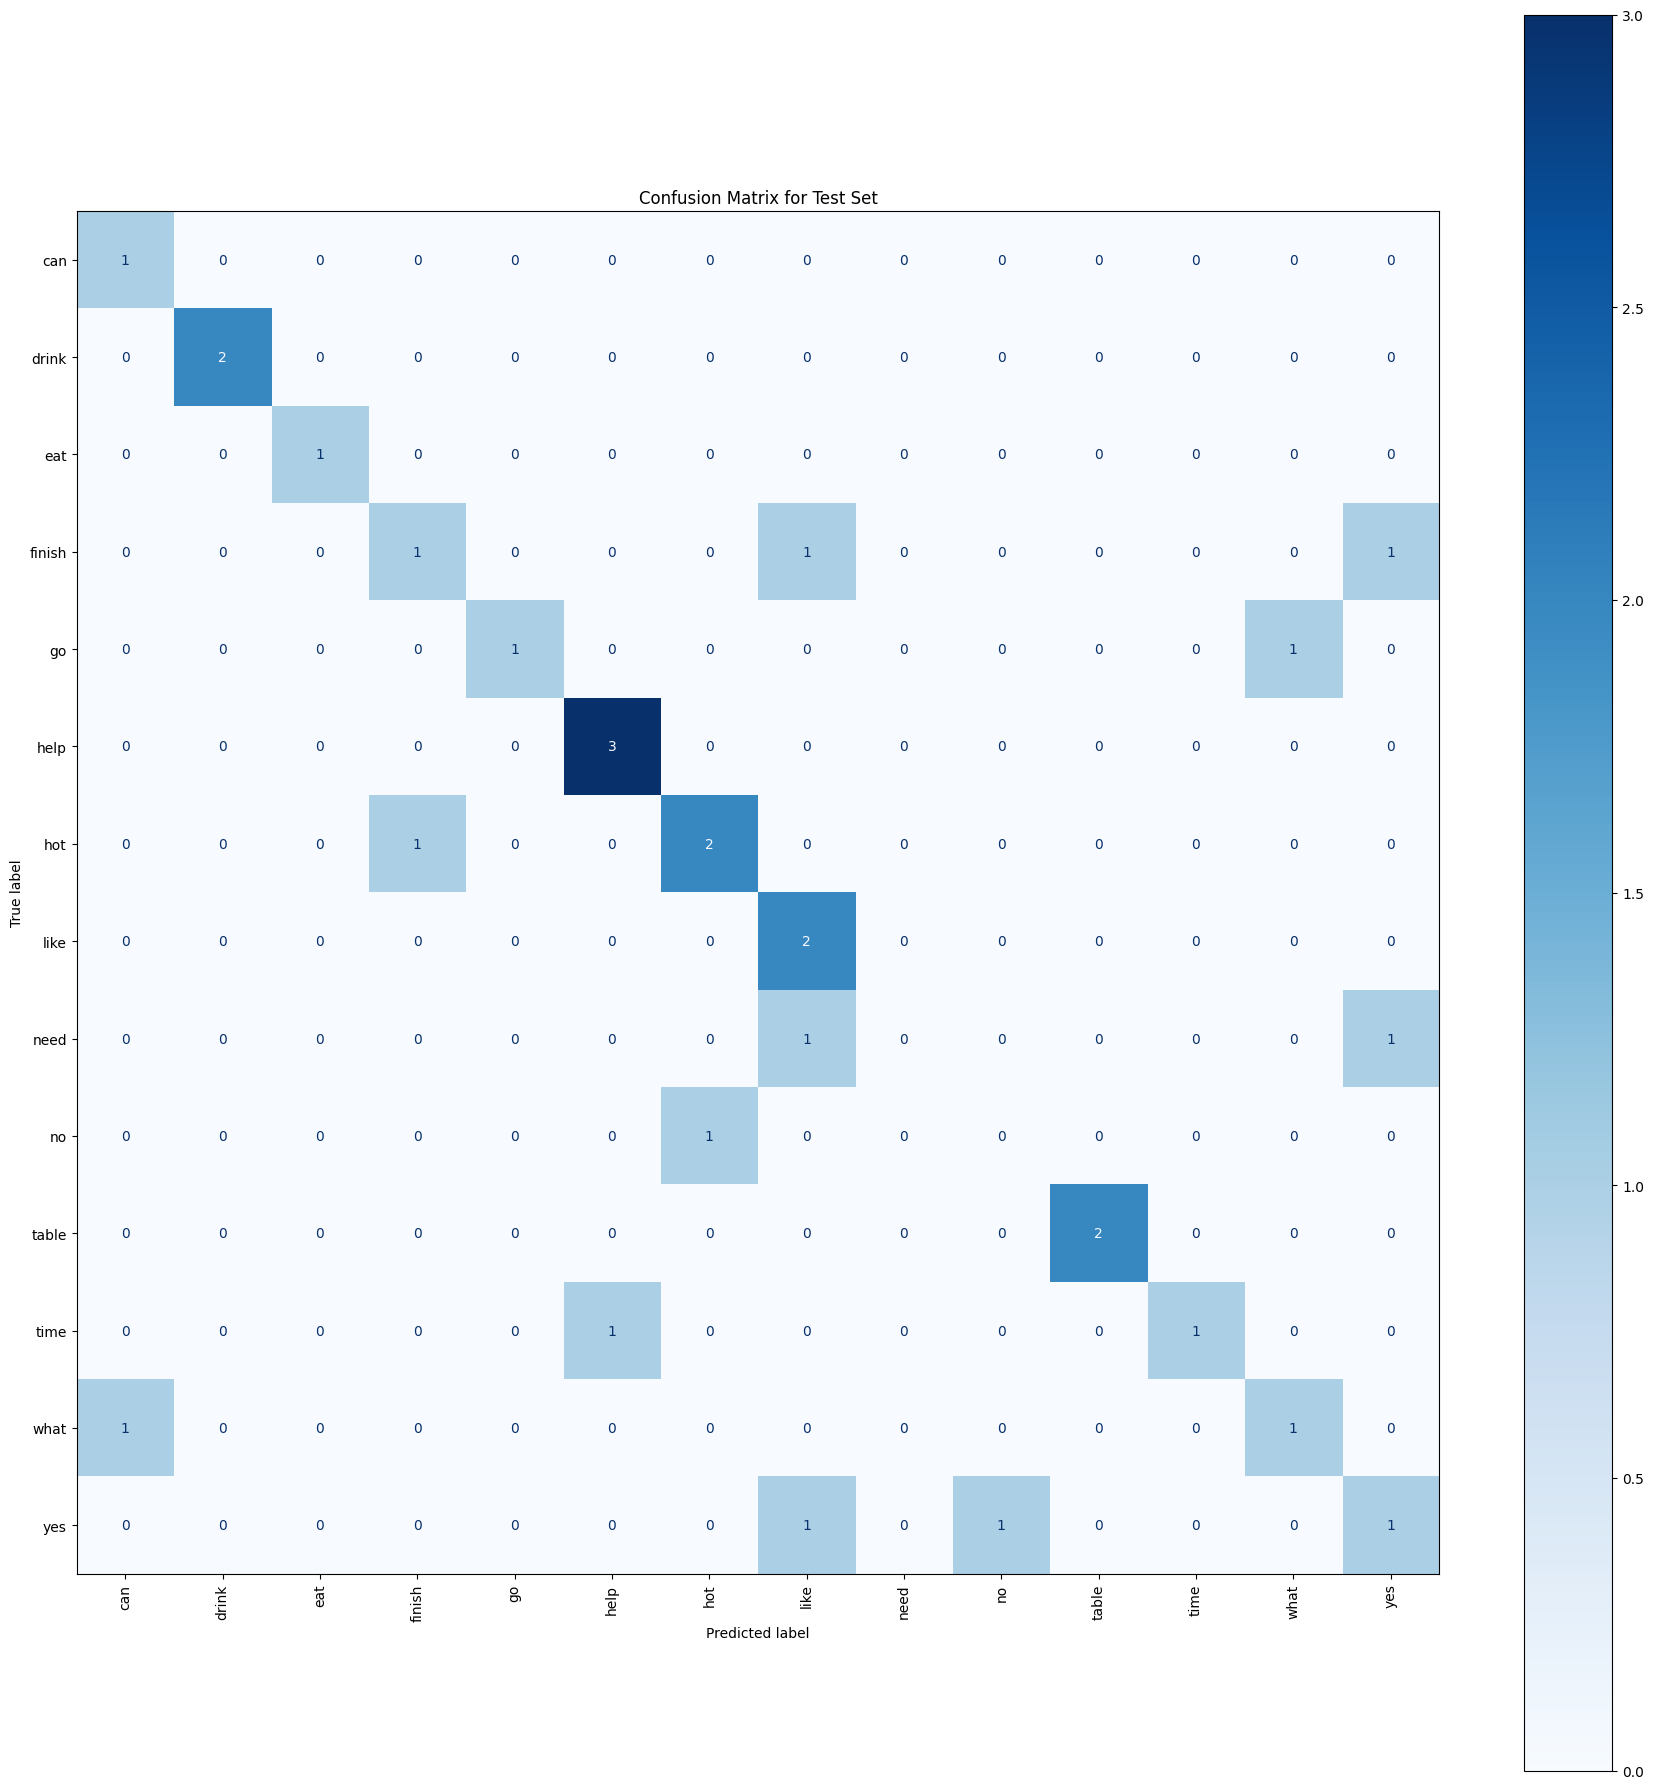

In [13]:

# Make sure scikit-learn and matplotlib are installed for the optional confusion matrix
# pip install scikit-learn matplotlib
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# --- Ensure required variables exist ---
# These should be available from your previous notebook cells:
# model: Your trained PyTorch model
# test_loader: Your PyTorch DataLoader for the test set
# NUM_CLASSES: The number of classes (e.g., 50)
# device: The device ('cpu' or 'cuda')
# id_to_gloss: Dictionary mapping class index to gloss name

# --- Load id_to_gloss mapping if it doesn't exist in the current scope ---
if 'id_to_gloss' not in locals(): # Check if it exists
    data_file = 'prepared_data.npz' # File where prepare_data.py saved arrays
    if os.path.exists(data_file):
        print(f"Loading id_to_gloss mapping from {data_file}...")
        try:
            # allow_pickle=True is needed if you saved a dictionary object
            data = np.load(data_file, allow_pickle=True)
            # .item() retrieves the dictionary saved as a 0-d object array
            id_to_gloss = data['id_to_gloss'].item()
            print("id_to_gloss loaded successfully.")
            # Verify NUM_CLASSES matches the loaded mapping
            if len(id_to_gloss) != NUM_CLASSES:
                 print(f"Warning: NUM_CLASSES ({NUM_CLASSES}) from config does not match length of loaded id_to_gloss ({len(id_to_gloss)}). Adjusting NUM_CLASSES.")
                 NUM_CLASSES = len(id_to_gloss) # Adjust NUM_CLASSES based on loaded data
        except KeyError:
            print(f"Error: 'id_to_gloss' key not found in {data_file}. Cannot display class names.")
            # Create a dummy mapping to prevent errors later
            id_to_gloss = {i: f"Class_{i}" for i in range(NUM_CLASSES)}
        except Exception as e:
            print(f"Error loading id_to_gloss from {data_file}: {e}")
            print("Cannot display class names.")
            id_to_gloss = {i: f"Class_{i}" for i in range(NUM_CLASSES)}
    else:
        print(f"Error: {data_file} not found. Cannot load id_to_gloss mapping.")
        print("Cannot display class names.")
        id_to_gloss = {i: f"Class_{i}" for i in range(NUM_CLASSES)}
# --- End loading id_to_gloss ---


print("\nEvaluating model on the Test Set...")
model.eval() # Set the model to evaluation mode (disables dropout, etc.)

# Initialize lists/arrays for storing metrics
class_correct = list(0. for i in range(NUM_CLASSES))
class_total = list(0. for i in range(NUM_CLASSES))
all_preds = []
all_labels = []

# Disable gradient calculations during evaluation for efficiency
with torch.no_grad():
    # Iterate through batches in the test loader
    for sequences, labels in test_loader:
        # Move data to the configured device (CPU or GPU)
        sequences = sequences.to(device)
        labels = labels.to(device)

        # Get model predictions (raw scores/logits)
        outputs = model(sequences)
        # Find the index of the highest score (predicted class) for each sample
        _, predicted = torch.max(outputs.data, 1)

        # Store predictions and true labels for overall metrics and confusion matrix
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Check which predictions were correct
        correct_predictions = (predicted == labels).squeeze()

        # Update per-class counts based on the batch results
        # Handle cases where batch size might be 1 (last batch) or more
        if labels.size(0) == 1: # If only one sample in the batch
             label_index = labels[0].item() # Get the true label index
             # Add 1 to correct count if prediction was right, 0 otherwise
             class_correct[label_index] += correct_predictions.item()
             class_total[label_index] += 1 # Increment total count for this class
        else: # If multiple samples in the batch
            for i in range(labels.size(0)):
                label_index = labels[i].item() # Get true label for this sample
                # Add 1 if the i-th prediction was correct, 0 otherwise
                class_correct[label_index] += correct_predictions[i].item()
                class_total[label_index] += 1 # Increment total count for this class

# --- Calculate and Print Overall Accuracy ---
total_correct_predictions = sum(class_correct)
total_test_samples = sum(class_total)

if total_test_samples > 0:
    overall_accuracy = 100 * total_correct_predictions / total_test_samples
    print(f'\nOverall Accuracy on the Test Set: {overall_accuracy:.2f}% ({int(total_correct_predictions)}/{int(total_test_samples)})')
else:
    print("\nError: No samples found in the test set to evaluate.")

# --- Calculate and Print Per-Class Accuracy ---
print("\nAccuracy per class:")
for i in range(NUM_CLASSES):
    # Get the gloss name using the index, provide default if not found
    gloss_name = id_to_gloss.get(i, f"Unknown Class {i}")
    # Calculate accuracy only if there were samples of this class in the test set
    if class_total[i] > 0:
        accuracy = 100 * class_correct[i] / class_total[i]
        # Print class name, accuracy percentage, and raw counts (correct/total)
        print(f'  - {gloss_name}: {accuracy:.2f}% ({int(class_correct[i])}/{int(class_total[i])})')
    else:
        # Indicate classes that had no samples in the test set
        print(f'  - {gloss_name}: N/A (0 samples in test set)')


# --- Optional: Display Confusion Matrix ---
print("\nGenerating Confusion Matrix...")
# Check if there are any predictions to plot
if all_labels and all_preds:
    try:
        # Calculate the confusion matrix
        cm = confusion_matrix(all_labels, all_preds, labels=range(NUM_CLASSES))
        # Get labels in the correct order for the plot axes
        display_labels = [id_to_gloss.get(i, f"Class_{i}") for i in range(NUM_CLASSES)]

        # Set up the plot figure size (increase for better readability with many classes)
        fig, ax = plt.subplots(figsize=(18, 18)) # Adjust size as needed

        # Create the display object
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)

        # Plot the confusion matrix
        # cmap=plt.cm.Blues: color map
        # ax=ax: specify the axes to plot on
        # xticks_rotation='vertical': rotate x-axis labels for readability
        # values_format='d': display counts as integers
        disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical', values_format='d')

        plt.title("Confusion Matrix for Test Set")
        plt.tight_layout() # Adjust layout to prevent labels overlapping axes
        plt.show() # Display the plot
    except ImportError:
        print("\nCould not generate confusion matrix.")
        print("Please install scikit-learn and matplotlib:")
        print("  pip install scikit-learn matplotlib")
    except Exception as e:
        print(f"\nAn error occurred while generating the confusion matrix: {e}")
else:
    print("Skipping confusion matrix: No predictions or labels available.")

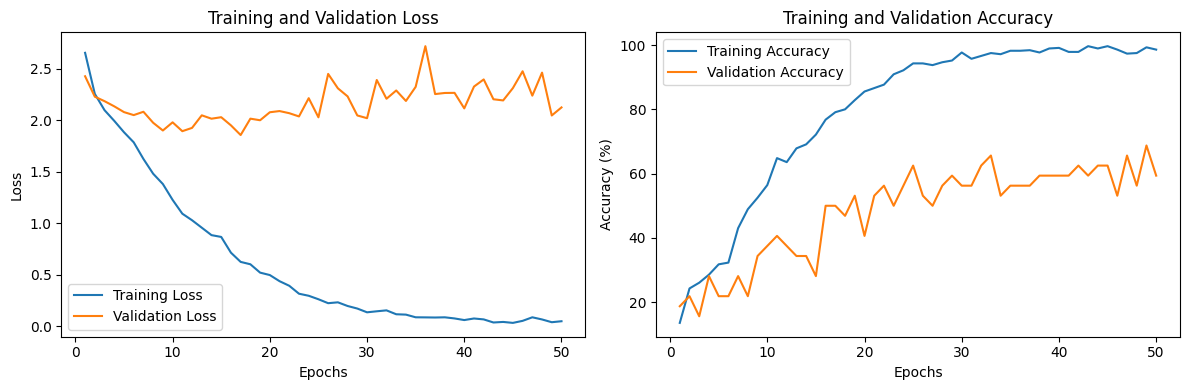

In [14]:
import matplotlib.pyplot as plt

epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
# 1) Save trained model weights (state_dict)
from notebook_export_helpers import save_model_state
save_model_state(model, "pose_transformer.pth")


# 2) Extract id_to_gloss dict from your NPZ and save JSONs
#    - Adjust npz_path and key if needed
import numpy as np
from notebook_export_helpers import (
    save_id_to_gloss_from_npz,     # NPZ -> list JSON (+ optional dict JSON)
    id_to_gloss_list_from_dict,    # dict -> list
    save_id_to_gloss,              # list -> JSON
    save_id_to_gloss_dict          # dict -> JSON
)

npz_path = "prepared_subset_data.npz"  # change if yours differs
key = "id_to_gloss"                               # change if yours differs

# Option A: Directly from NPZ in one call (also optionally saves the raw dict JSON)
save_id_to_gloss_from_npz(
    npz_path=npz_path,
    key=key,
    out_json_list="id_to_gloss.json",
    out_json_dict="id_to_gloss_dict.json"  # optional, remove if not needed
)

# Option B: If you already loaded it in this notebook as 'data':
# data = np.load(npz_path, allow_pickle=True)
# id_to_gloss_dict = data[key].item()  # your extraction
# mapping_list = id_to_gloss_list_from_dict(id_to_gloss_dict)
# save_id_to_gloss(mapping_list, "start_kit/id_to_gloss.json")
# save_id_to_gloss_dict(id_to_gloss_dict, "start_kit/id_to_gloss_dict.json")  # optional

Saved model weights to pose_transformer.pth
Saved id_to_gloss list (length 14) to id_to_gloss.json
Saved id_to_gloss dict with 14 entries to id_to_gloss_dict.json


<h1>Applying kfold</h1> 


In [25]:
#preparing data  normalizing it ,padding and truncation, generating all_data_for_kfold.npz
import numpy as np
import os
import json
from data_reader import load_data # Import from your corrected data_reader.py

# --- Configuration ---
JSON_FILE = 'WLASL_Cafe.json'
LANDMARK_FOLDER = 'landmarks'
MAX_SEQ_LENGTH = 100
OUTPUT_NPZ_FILE = 'all_data_for_kfold.npz' # New single output file

# --- Load Config for 300 Features ---
NUM_POSE = 33
NUM_HAND = 21
NUM_LANDMARKS = NUM_POSE + (2 * NUM_HAND)  # 75 total
NUM_VALUES_PER_LANDMARK = 4
EXPECTED_FEATURES = NUM_LANDMARKS * NUM_VALUES_PER_LANDMARK # 300

# --- <<< STEP 1: DEFINE YOUR SUBSET OF GLOSSES >>> ---
VIABLE_GLOSSES = [
    'can', 'drink', 'eat', 'finish', 'go', 'help', 'hot', 'like',
    'need', 'no', 'table', 'time', 'what', 'yes' 
]
print(f"Targeting a subset of {len(VIABLE_GLOSSES)} glosses.")
# --- <<< END STEP 1 >>> ---


# --- Step 2: Load ALL Labels First ---
print(f"Loading all labels from {JSON_FILE}...")
all_instances_full = load_data(JSON_FILE)
if not all_instances_full:
    raise Exception("Data loading failed")

# --- Step 3: Filter Instances for Subset ---
print(f"Filtering instances for the {len(VIABLE_GLOSSES)} viable glosses...")
all_instances_subset = [
    inst for inst in all_instances_full if inst.get('gloss') in VIABLE_GLOSSES
]
if not all_instances_subset:
    raise Exception("No instances found for subset")
print(f"Found {len(all_instances_subset)} instances for the subset.")

# --- Step 4: Create Lookup Dictionary (No 'split' needed) ---
video_to_gloss = {}
found_ids_in_json_subset = set()
for instance in all_instances_subset:
    video_id = instance.get('video_id')
    gloss = instance.get('gloss')
    if video_id and gloss:
        video_to_gloss[video_id] = gloss
        found_ids_in_json_subset.add(video_id)

print(f"Created lookup dictionary for {len(video_to_gloss)} entries.")

# --- Step 5: Label Encoding ---
print("Encoding labels for the subset...")
subset_glosses = sorted(list(set(video_to_gloss.values())))
gloss_to_id = {gloss: i for i, gloss in enumerate(subset_glosses)}
id_to_gloss = {i: gloss for i, gloss in enumerate(subset_glosses)}
num_classes = len(subset_glosses)
print(f"Found {num_classes} unique glosses in the subset.")

# --- Helper Functions (Normalization and Padding) ---
# (These functions are identical to before)
def normalize_landmarks(landmarks):
    normalized_video = np.copy(landmarks)
    num_frames = landmarks.shape[0]
    num_features_per_frame = landmarks.shape[1]
    if num_features_per_frame != EXPECTED_FEATURES:
         return landmarks
    for frame_idx in range(num_frames):
        frame_data = landmarks[frame_idx]
        frame_reshaped = frame_data.reshape((NUM_LANDMARKS, NUM_VALUES_PER_LANDMARK))
        pose_landmarks = frame_reshaped[:NUM_POSE]
        nose_x, nose_y = pose_landmarks[0, 0], pose_landmarks[0, 1]
        nose_visibility = pose_landmarks[0, 3]
        if nose_visibility > 0.1:
            frame_reshaped[:, 0] -= nose_x
            frame_reshaped[:, 1] -= nose_y
        else:
            frame_reshaped[:, :3] = 0.0
        normalized_video[frame_idx] = frame_reshaped.flatten()
    return normalized_video

def pad_truncate(landmarks, max_len):
    num_frames = landmarks.shape[0]
    num_features = landmarks.shape[1]
    padded_landmarks = np.zeros((max_len, num_features), dtype=np.float32)
    seq_len_to_use = min(num_frames, max_len)
    padded_landmarks[:seq_len_to_use] = landmarks[:seq_len_to_use]
    return padded_landmarks

# --- Step 6: Load ALL Landmarks (No Splitting) ---
print(f"\nProcessing all subset landmark files from '{LANDMARK_FOLDER}'...")
X_data_list = [] # One list for all data
y_data_list = [] # One list for all labels

processed_ids_subset = set()

for video_id in video_to_gloss.keys():
    landmark_file = f"{video_id}.npy"
    landmark_path = os.path.join(LANDMARK_FOLDER, landmark_file)

    if os.path.exists(landmark_path):
        processed_ids_subset.add(video_id)
        gloss = video_to_gloss[video_id]

        try:
            landmarks = np.load(landmark_path)
            if landmarks.size == 0 or landmarks.shape[0] == 0:
                 continue
            if len(landmarks.shape) != 2 or landmarks.shape[1] != EXPECTED_FEATURES:
                 print(f"Warning: Skipping {video_id} ({gloss}). Shape {landmarks.shape} != (frames, {EXPECTED_FEATURES})")
                 continue

            normalized_data = normalize_landmarks(landmarks)
            padded_data = pad_truncate(normalized_data, MAX_SEQ_LENGTH)
            label_id = gloss_to_id[gloss]

            # --- Append to the single master list ---
            X_data_list.append(padded_data)
            y_data_list.append(label_id)
            
        except Exception as e:
            print(f"Error processing {landmark_file} ({gloss}): {e}")

# --- Step 7: Convert to NumPy Arrays ---
print("\nConverting all data to NumPy arrays...")
X_data = np.array(X_data_list, dtype=np.float32)
y_data = np.array(y_data_list, dtype=np.int64)

# --- Step 8: Save the Single Dataset ---
print(f"\nSaving prepared data arrays to {OUTPUT_NPZ_FILE}...")
np.savez(
    OUTPUT_NPZ_FILE,
    X_data=X_data,
    y_data=y_data,
    id_to_gloss=id_to_gloss # Save the SUBSET mapping
)
print("Complete data saved successfully.")

# --- Final Summary ---
print("\n--- K-Fold Data Preparation Complete ---")
print(f"Total samples prepared: {len(X_data)}")
print("Data shapes:", X_data.shape, y_data.shape)
print("Number of classes:", num_classes)
print("---------------------------------------")

Targeting a subset of 14 glosses.
Loading all labels from WLASL_Cafe.json...
Loaded 839 video instances from WLASL_Cafe.json
Filtering instances for the 14 viable glosses...
Found 308 instances for the subset.
Created lookup dictionary for 308 entries.
Encoding labels for the subset...
Found 14 unique glosses in the subset.

Processing all subset landmark files from 'landmarks'...

Converting all data to NumPy arrays...

Saving prepared data arrays to all_data_for_kfold.npz...
Complete data saved successfully.

--- K-Fold Data Preparation Complete ---
Total samples prepared: 173
Data shapes: (173, 100, 300) (173,)
Number of classes: 14
---------------------------------------


In [26]:
#neccesary imports and configs we need 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import math
import os
from sklearn.model_selection import StratifiedKFold # <<< IMPORT THIS
import matplotlib.pyplot as plt # For plotting

# --- Configuration ---
NUM_CLASSES = 14       # This should match the output from the prep script
MAX_SEQ_LENGTH = 100
INPUT_FEATURES = 300   # 75 * 4
K_FOLDS = 5            # <<< SET NUMBER OF FOLDS (5 is standard)

# Model Hyperparameters
EMBED_DIM = 256
NUM_HEADS = 8
NUM_ENCODER_LAYERS = 3
DIM_FEEDFORWARD = 512
DROPOUT = 0.3          # Your best dropout
WEIGHT_DECAY = 1e-4    # Your regularization

# Training Hyperparameters
LEARNING_RATE = 0.0001
BATCH_SIZE = 16
EPOCHS = 50            # Max epochs per fold (Early Stopping will handle this)
PATIENCE = 10          # Patience for Early Stopping

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Starting {K_FOLDS}-Fold Cross-Validation...")

Using device: cpu
Starting 5-Fold Cross-Validation...


In [27]:

class PositionalEncoding(nn.Module):
    """Adds positional information to the input sequence embeddings."""
    def __init__(self, d_model, dropout=0.2, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1) # Shape: (max_len, 1, d_model)
        self.register_buffer('pe', pe) # Makes 'pe' part of the model state but not a parameter

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

print("PositionalEncoding class defined.")

PositionalEncoding class defined.


In [28]:
#cell 5
class PoseTransformer(nn.Module):
    """Transformer model for pose sequence classification."""
    def __init__(self, input_dim, embed_dim, num_heads, num_layers, dim_feedforward, num_classes, max_seq_len, dropout=0.2):
        super(PoseTransformer, self).__init__()
        self.embed_dim = embed_dim
        
        # Input embedding layer (Linear layer to project input features)
        self.input_embedding = nn.Linear(input_dim, embed_dim)
        
        # Positional Encoding
        self.pos_encoder = PositionalEncoding(embed_dim, dropout, max_len=max_seq_len)
        
        # Standard PyTorch Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, 
                                                   dim_feedforward=dim_feedforward, dropout=dropout, 
                                                   batch_first=False) # Important: PyTorch default expects (Seq, Batch, Feature)
        encoder_norm = nn.LayerNorm(embed_dim)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers, norm=encoder_norm)
        
        # Classification head
        self.fc_out = nn.Linear(embed_dim, num_classes)

        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.input_embedding.weight.data.uniform_(-initrange, initrange)
        self.input_embedding.bias.data.zero_()
        self.fc_out.weight.data.uniform_(-initrange, initrange)
        self.fc_out.bias.data.zero_()

    def forward(self, src):
        """
        Args:
            src: Tensor, shape [batch_size, seq_len, input_dim]
        """
        # --- Reshape for PyTorch Transformer ---
        # Input shape: (Batch, Seq, Feature) -> (Seq, Batch, Feature)
        src = src.transpose(0, 1) 
        
        # --- Processing ---
        src = self.input_embedding(src) * math.sqrt(self.embed_dim) # Embed input
        src = self.pos_encoder(src) # Add positional encoding
        output = self.transformer_encoder(src) # Pass through Transformer Encoder
        
        # --- Classification ---
        # Use the output corresponding to the first token ([CLS] token analogy) 
        # or average pooling over the sequence. Here we use the first token's output.
        output = output[0, :, :] # Take output of the first time step -> Shape: (Batch, Feature)
        # Alternatively, mean pooling: output = output.mean(dim=0) # Shape: (Batch, Feature)

        output = self.fc_out(output) # Final classification layer
        return output # Logits output, CrossEntropyLoss applies softmax internally

print("PoseTransformer class defined.")

PoseTransformer class defined.


In [32]:
import numpy as np

def rotate_landmarks(landmarks, angle_deg):
    """Rotates 2D landmarks (x, y) around the origin (0,0)."""
    angle_rad = np.radians(angle_deg)
    cos_a = np.cos(angle_rad)
    sin_a = np.sin(angle_rad)
    # Rotation matrix for 2D
    rotation_matrix = np.array([[cos_a, -sin_a],
                                [sin_a,  cos_a]], dtype=np.float32)
    
    # We only rotate x,y. z and visibility are left alone.
    # landmarks shape is (num_frames, 300)
    # Reshape to (num_frames, 75, 4)
    num_frames = landmarks.shape[0]
    # Ensure correct feature count before reshaping
    if landmarks.shape[1] != 300:
        print(f"Warning: rotate_landmarks expected 300 features, got {landmarks.shape[1]}")
        return landmarks
        
    landmarks_reshaped = landmarks.reshape(num_frames, 75, 4)
    
    # Apply rotation to x,y coordinates
    # (num_frames, 75, 2)
    xy_coords = landmarks_reshaped[:, :, :2]
    
    # Apply rotation
    # 'fji,ik->fjk' means:
    # f=frames, j=landmarks, i=in_coords (x,y)
    # i=in_coords, k=out_coords (x',y')
    # Output: f=frames, j=landmarks, k=out_coords
    
    # --- THIS IS THE CORRECTED LINE ---
    rotated_xy = np.einsum('fji,ik->fjk', xy_coords, rotation_matrix)
    
    # Put the rotated data back
    landmarks_reshaped[:, :, :2] = rotated_xy
    
    return landmarks_reshaped.reshape(num_frames, 300) # Flatten back

def scale_landmarks(landmarks, scale_factor):
    """Scales 2D landmarks (x, y) from the origin (0,0)."""
    # We only scale x,y. z and visibility are left alone.
    num_frames = landmarks.shape[0]
    
    if landmarks.shape[1] != 300:
        print(f"Warning: scale_landmarks expected 300 features, got {landmarks.shape[1]}")
        return landmarks
        
    landmarks_reshaped = landmarks.reshape(num_frames, 75, 4)
    
    # Apply scaling to x,y coordinates
    landmarks_reshaped[:, :, :2] *= scale_factor
    
    return landmarks_reshaped.reshape(num_frames, 300)

print("Augmentation functions (rotate_landmarks, scale_landmarks) defined.")

Augmentation functions (rotate_landmarks, scale_landmarks) defined.


In [30]:
# (In your K-Fold Training Cell)

AUGMENTATION_FACTOR = 4
NOISE_LEVEL = 0.005 # Can keep this low since we have other augs
ROTATION_DEGREES = 10 # Max random rotation (e.g., -10 to +10 degrees)
SCALE_RANGE = (0.85, 1.15) # Max random scale (e.g., 85% to 115%)

def augment_data(X_train_fold, y_train_fold):
    print(f"  Augmenting {len(X_train_fold)} training samples...")
    X_train_aug = []
    y_train_aug = []

    for i in range(len(X_train_fold)):
        original_sample = X_train_fold[i]
        original_label = y_train_fold[i]
        
        # 1. Add the original sample
        X_train_aug.append(original_sample)
        y_train_aug.append(original_label)
        
        # 2. Add augmented copies
        for _ in range(AUGMENTATION_FACTOR):
            augmented_sample = original_sample.copy()
            
            # --- Apply New Augmentations ---
            
            # 1. Random Rotation
            angle = np.random.uniform(-ROTATION_DEGREES, ROTATION_DEGREES)
            augmented_sample = rotate_landmarks(augmented_sample, angle)
            
            # 2. Random Scaling
            scale = np.random.uniform(SCALE_RANGE[0], SCALE_RANGE[1])
            augmented_sample = scale_landmarks(augmented_sample, scale)
            
            # 3. Time Masking (from before)
            if np.random.rand() < 0.5: # 50% chance
                mask_len = int(MAX_SEQ_LENGTH * 0.15)
                mask_start = np.random.randint(0, MAX_SEQ_LENGTH - mask_len)
                augmented_sample[mask_start : mask_start + mask_len] = 0.0
                
            # 4. Noise (from before)
            noise = np.random.normal(loc=0.0, scale=NOISE_LEVEL, size=augmented_sample.shape)
            augmented_sample = augmented_sample + noise
            # --- End Augmentations ---

            X_train_aug.append(augmented_sample)
            y_train_aug.append(original_label)

    print(f"  New training set size: {len(X_train_aug)}")
    return np.array(X_train_aug, dtype=np.float32), np.array(y_train_aug, dtype=np.int64)

In [21]:
#this is the main cell for training model in each fold:  it is calling augmented_data() for each fold getting augmented data and training on that and getting accuracy for each fold
# --- Load the single, combined dataset ---
print("Loading all_data_for_kfold.npz...")
data = np.load('all_data_for_kfold.npz', allow_pickle=True)
X_data = data['X_data']
y_data = data['y_data']
id_to_gloss = data['id_to_gloss'].item() # Load the mapping
print(f"Loaded {len(X_data)} total samples.")

# --- Initialize K-Fold ---
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

# Store results for each fold
fold_accuracies = []

# --- OUTER LOOP: Iterate through each fold ---
for fold, (train_indices, val_indices) in enumerate(skf.split(X_data, y_data)):
    print(f"\n--- FOLD {fold + 1}/{K_FOLDS} ---")
    
    # --- 1. Create this fold's Train and Validation sets ---
    X_train_fold, X_val_fold = X_data[train_indices], X_data[val_indices]
    y_train_fold, y_val_fold = y_data[train_indices], y_data[val_indices]
    
    print(f"Train samples: {len(X_train_fold)}, Validation samples: {len(X_val_fold)}")

    # --- 2. Augment ONLY the training data for this fold ---
    X_train_aug, y_train_aug = augment_data(X_train_fold, y_train_fold)

    # --- 3. Create DataLoaders for this fold ---
    train_dataset = TensorDataset(torch.from_numpy(X_train_aug), torch.from_numpy(y_train_aug))
    val_dataset = TensorDataset(torch.from_numpy(X_val_fold), torch.from_numpy(y_val_fold))
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    # --- 4. Re-initialize the Model and Optimizer ---
    # (CRITICAL: A new, untrained model for each fold)
    model = PoseTransformer(
        input_dim=INPUT_FEATURES,
        embed_dim=EMBED_DIM,
        num_heads=NUM_HEADS,
        num_layers=NUM_ENCODER_LAYERS,
        dim_feedforward=DIM_FEEDFORWARD,
        num_classes=NUM_CLASSES,
        max_seq_len=MAX_SEQ_LENGTH,
        dropout=DROPOUT
    ).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    
    # --- 5. Inner Loop: Training Epochs (with Early Stopping) ---
    best_val_acc = 0.0
    patience_counter = 0
    best_model_state = None
    
    print(f"Starting training for Fold {fold + 1}...")
    for epoch in range(EPOCHS):
        model.train()
        for sequences, labels in train_loader:
            sequences = sequences.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        # Validation
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for sequences, labels in val_loader:
                sequences = sequences.to(device)
                labels = labels.to(device)
                outputs = model(sequences)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        epoch_val_acc = 100 * correct_val / total_val
        print(f"  Epoch {epoch+1}/{EPOCHS} | Val Acc: {epoch_val_acc:.2f}%")
        
        # Early Stopping Check
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            patience_counter = 0
            best_model_state = model.state_dict() # Save the best model
        else:
            patience_counter += 1
            
        if patience_counter >= PATIENCE:
            print(f"  Early stopping triggered at epoch {epoch+1}.")
            break
    

    print(f"Fold {fold + 1} Best Validation Accuracy: {best_val_acc:.2f}%")
    fold_accuracies.append(best_val_acc)   
    print(f"Fold {fold + 1} Best Validation Accuracy: {best_val_acc:.2f}%")
    fold_accuracies.append(best_val_acc)
    
    # Optional: Save the best model for this fold
    # torch.save(best_model_state, f"model_fold_{fold+1}.pth")

# --- 6. Final Results ---
print("\n--- K-Fold Cross-Validation Complete ---")
print(f"Fold accuracies: {[round(acc, 2) for acc in fold_accuracies]}")
print(f"Average Accuracy: {np.mean(fold_accuracies):.2f}%")
print(f"Standard Deviation: {np.std(fold_accuracies):.2f}")

Loading all_data_for_kfold.npz...
Loaded 173 total samples.

--- FOLD 1/5 ---
Train samples: 138, Validation samples: 35
  Augmenting 138 training samples...
  New training set size: 1242


C:\Users\hp\OneDrive\Desktop\mjwithopencv\TrainEnvironment\Lib\site-packages\torch\nn\modules\transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Starting training for Fold 1...
  Epoch 1/50 | Val Acc: 22.86%
  Epoch 2/50 | Val Acc: 25.71%
  Epoch 3/50 | Val Acc: 31.43%
  Epoch 4/50 | Val Acc: 42.86%
  Epoch 5/50 | Val Acc: 42.86%
  Epoch 6/50 | Val Acc: 57.14%
  Epoch 7/50 | Val Acc: 48.57%
  Epoch 8/50 | Val Acc: 51.43%
  Epoch 9/50 | Val Acc: 45.71%
  Epoch 10/50 | Val Acc: 40.00%
  Epoch 11/50 | Val Acc: 48.57%
  Epoch 12/50 | Val Acc: 48.57%
  Epoch 13/50 | Val Acc: 48.57%
  Epoch 14/50 | Val Acc: 48.57%
  Epoch 15/50 | Val Acc: 57.14%
  Epoch 16/50 | Val Acc: 57.14%
  Early stopping triggered at epoch 16.
Fold 1 Best Validation Accuracy: 57.14%

--- FOLD 2/5 ---
Train samples: 138, Validation samples: 35
  Augmenting 138 training samples...
  New training set size: 1242
Starting training for Fold 2...
  Epoch 1/50 | Val Acc: 11.43%
  Epoch 2/50 | Val Acc: 11.43%
  Epoch 3/50 | Val Acc: 34.29%
  Epoch 4/50 | Val Acc: 28.57%
  Epoch 5/50 | Val Acc: 34.29%
  Epoch 6/50 | Val Acc: 25.71%
  Epoch 7/50 | Val Acc: 40.00%
  Epoch 

In [23]:
# --- ADD THIS LINE ---
if best_model_state:
    save_path = f"model_fold_{fold+1}.pth"
    torch.save(best_model_state, save_path)
    print(f"  --> Best model for Fold {fold+1} saved to {save_path}")
    # --- END OF ADDED CODE ---

  --> Best model for Fold 5 saved to model_fold_5.pth


In [33]:
print("--- Starting final model training on ALL data ---")

# --- 1. Load ALL data ---
data = np.load('all_data_for_kfold.npz', allow_pickle=True)
X_data = data['X_data']
y_data = data['y_data']
id_to_gloss = data['id_to_gloss'].item()
num_classes = len(id_to_gloss)
print(f"Loaded {len(X_data)} total samples for training.")

# --- 2. Augment ALL data ---
# (Using the same augmentation function from your K-Fold cell)
X_train_final, y_train_final = augment_data(X_data, y_data)

# --- 3. Create one DataLoader ---
final_train_dataset = TensorDataset(torch.from_numpy(X_train_final), torch.from_numpy(y_train_final))
final_train_loader = DataLoader(final_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
print(f"Final augmented training set size: {len(X_train_final)}")

# --- 4. Initialize the final model ---
final_model = PoseTransformer(
    input_dim=INPUT_FEATURES,
    embed_dim=EMBED_DIM,
    num_heads=NUM_HEADS,
    num_layers=NUM_ENCODER_LAYERS,
    dim_feedforward=DIM_FEEDFORWARD,
    num_classes=num_classes, # Use num_classes from loaded data
    max_seq_len=MAX_SEQ_LENGTH,
    dropout=DROPOUT
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(final_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# --- 5. Train the final model ---
# We can't use Early Stopping (no validation set), so we train for an average number of epochs.
# Your average was (16+38+33+21+50) / 5 = ~32 epochs. Let's use 30.
FINAL_EPOCHS = 30 
print(f"Training final model for {FINAL_EPOCHS} epochs...")

final_model.train()
for epoch in range(FINAL_EPOCHS):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for sequences, labels in final_train_loader:
        sequences = sequences.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = final_model(sequences)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)    

    epoch_loss = running_loss / len(final_train_loader)
    epoch_acc = 100 * correct_train / total_train
    print(f"Epoch [{epoch+1}/{FINAL_EPOCHS}] | Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.2f}%")

# --- 6. Save the final model ---
FINAL_MODEL_PATH = "final_pose_transformer.pth"
torch.save(final_model.state_dict(), FINAL_MODEL_PATH)
print(f"\n--- Final Model Saved to {FINAL_MODEL_PATH} ---")

--- Starting final model training on ALL data ---
Loaded 173 total samples for training.
  Augmenting 173 training samples...
  New training set size: 865
Final augmented training set size: 865
Training final model for 30 epochs...
Epoch [1/30] | Train Loss: 2.5436 | Train Acc: 11.10%
Epoch [2/30] | Train Loss: 2.2348 | Train Acc: 20.12%
Epoch [3/30] | Train Loss: 2.0656 | Train Acc: 26.59%
Epoch [4/30] | Train Loss: 1.9631 | Train Acc: 29.48%
Epoch [5/30] | Train Loss: 1.7989 | Train Acc: 34.80%
Epoch [6/30] | Train Loss: 1.6013 | Train Acc: 40.81%
Epoch [7/30] | Train Loss: 1.4243 | Train Acc: 46.59%
Epoch [8/30] | Train Loss: 1.3156 | Train Acc: 50.17%
Epoch [9/30] | Train Loss: 1.3102 | Train Acc: 50.17%
Epoch [10/30] | Train Loss: 1.1736 | Train Acc: 55.84%
Epoch [11/30] | Train Loss: 1.0486 | Train Acc: 59.42%
Epoch [12/30] | Train Loss: 0.9361 | Train Acc: 63.47%
Epoch [13/30] | Train Loss: 0.8979 | Train Acc: 64.74%
Epoch [14/30] | Train Loss: 0.8239 | Train Acc: 71.33%
Epoch [

In [34]:
#testing above final model on original data 
import torch
import torch.nn as nn
import numpy as np
import os
from torch.utils.data import TensorDataset, DataLoader

# --- Ensure required variables/functions are loaded ---
# (Run the cell that defines PoseTransformer, PositionalEncoding, etc., first if needed)
# (Run the cell that defines NUM_CLASSES, device, BATCH_SIZE, etc., first if needed)
# (Make sure 'id_to_gloss' is loaded from the .npz file)

print("\n--- Evaluating Final Model on Original Data ---")

# --- 1. Load the original, non-augmented data ---
# (This should still be in memory from your 'prepare_data' cell)
try:
    if 'X_data' not in locals() or 'y_data' not in locals():
        print("Loading original data from all_data_for_kfold.npz...")
        data = np.load('all_data_for_kfold.npz', allow_pickle=True)
        X_data = data['X_data']
        y_data = data['y_data']
        id_to_gloss = data['id_to_gloss'].item()
        print(f"Loaded {len(X_data)} original samples.")
except Exception as e:
    print(f"Error: Could not find or load 'X_data'/'y_data'. Please re-run the data prep cell. Error: {e}")
    # Stop here if data isn't loaded
    raise

# --- 2. Create a DataLoader for the original data ---
original_dataset = TensorDataset(torch.from_numpy(X_data).float(), torch.from_numpy(y_data).long())
original_loader = DataLoader(original_dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- 3. Load your trained final_model ---
# (This assumes 'final_model' is in memory. If not, load it)
if 'final_model' not in locals():
    print("Loading final_model from 'final_pose_transformer.pth'...")
    # Re-initialize the model structure
    final_model = PoseTransformer(
        input_dim=INPUT_FEATURES,
        embed_dim=EMBED_DIM,
        num_heads=NUM_HEADS,
        num_layers=NUM_ENCODER_LAYERS,
        dim_feedforward=DIM_FEEDFORWARD,
        num_classes=num_classes,
        max_seq_len=MAX_SEQ_LENGTH,
        dropout=DROPOUT
    ).to(device)
    # Load the saved weights
    final_model.load_state_dict(torch.load("final_pose_transformer.pth", map_location=device))
    print("Model loaded successfully.")

# --- 4. Run the evaluation loop ---
final_model.eval() 
correct_orig = 0
total_orig = 0
class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))

with torch.no_grad():
    for sequences, labels in original_loader:
        sequences = sequences.to(device)
        labels = labels.to(device)
        
        outputs = final_model(sequences)
        _, predicted = torch.max(outputs.data, 1)
        total_orig += labels.size(0)
        correct_orig += (predicted == labels).sum().item()
        
        # For per-class accuracy
        c = (predicted == labels).squeeze()
        if labels.size(0) == 1:
             label = labels[0].item()
             class_correct[label] += c.item()
             class_total[label] += 1
        else:
            for i in range(labels.size(0)):
                label = labels[i].item()
                class_correct[label] += c[i].item()
                class_total[label] += 1

original_accuracy = 100 * correct_orig / total_orig
print(f'\nOverall "Training" Accuracy on the {total_orig} ORIGINAL samples: {original_accuracy:.2f}% ({correct_orig}/{total_orig})')

# --- 5. Print Per-Class Accuracy ---
print("\nPer-Class 'Training' Accuracy (on Original Data):")
for i in range(num_classes):
    gloss_name = id_to_gloss.get(i, f"Unknown Class {i}")
    if class_total[i] > 0:
        accuracy = 100 * class_correct[i] / class_total[i]
        print(f'  - {gloss_name}: {accuracy:.2f}% ({int(class_correct[i])}/{int(class_total[i])})')
    else:
        print(f'  - {gloss_name}: N/A (0 samples)')


--- Evaluating Final Model on Original Data ---

Overall "Training" Accuracy on the 173 ORIGINAL samples: 97.11% (168/173)

Per-Class 'Training' Accuracy (on Original Data):
  - can: 100.00% (10/10)
  - drink: 100.00% (18/18)
  - eat: 100.00% (9/9)
  - finish: 92.86% (13/14)
  - go: 93.75% (15/16)
  - help: 100.00% (11/11)
  - hot: 100.00% (16/16)
  - like: 100.00% (16/16)
  - need: 100.00% (6/6)
  - no: 92.86% (13/14)
  - table: 100.00% (8/8)
  - time: 100.00% (8/8)
  - what: 81.82% (9/11)
  - yes: 100.00% (16/16)
